Creating partially labeled dataset
Class-wise pattern
Using 1 out of 3 clusters
Total labeled samples: 75 out of 1500 (5.00%)
Creating constraints
Number of ml constraints: 277
Number of cl constraints: 0
PCKmeans Iteration 1/1 with max diff 0.4522690291538196

===== Metrics Comparison =====
PCKmeans_NMI: 0.4065
KMeans_NMI: 0.4186
PCKmeans_Silhouette: 0.3679
KMeans_Silhouette: 0.4039
PCKmeans_ARI: 0.3609
KMeans_ARI: 0.3675
PCKmeans_DBI: 1.0076
KMeans_DBI: 0.8599


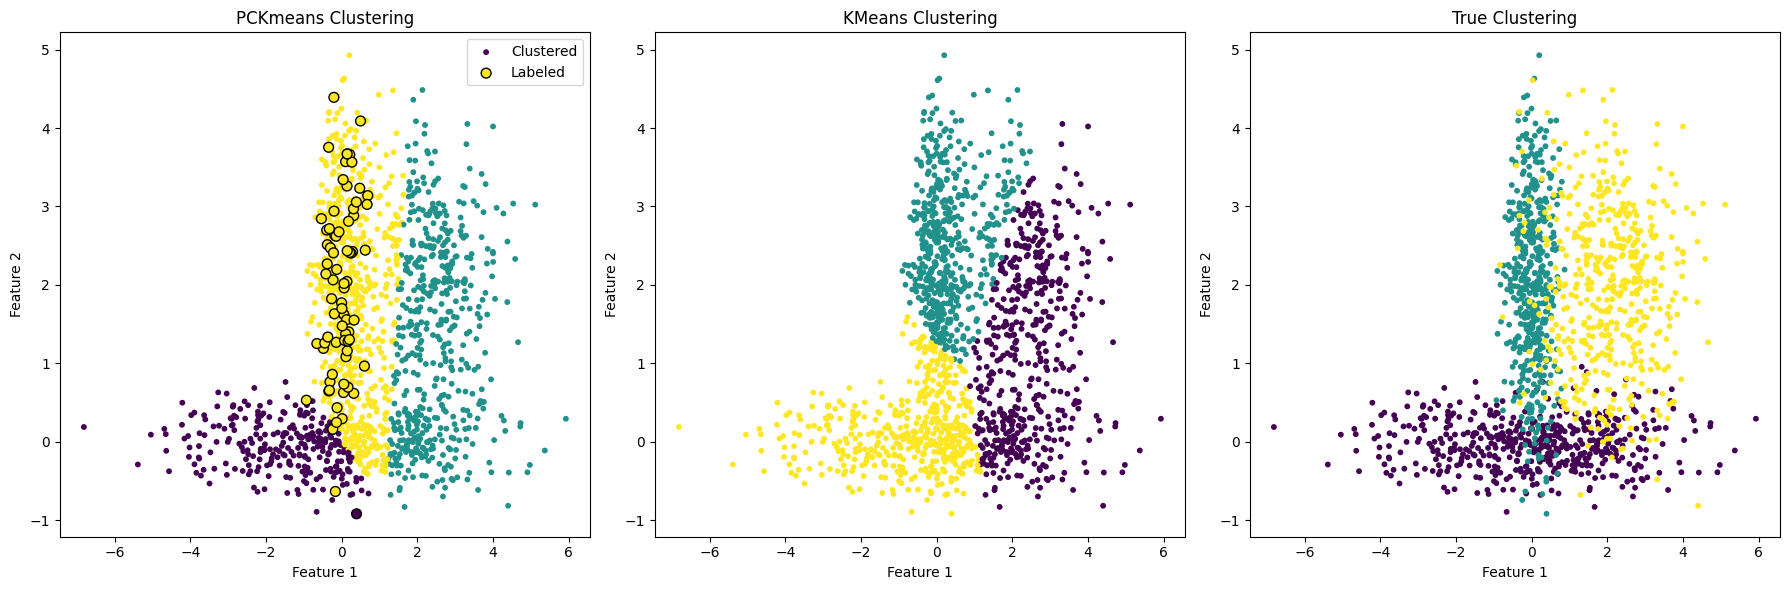

Creating partially labeled dataset
Class-wise pattern
Using 1 out of 3 clusters
Total labeled samples: 75 out of 1500 (5.00%)
Creating constraints
Number of ml constraints: 277
Number of cl constraints: 0
PCKmeans Iteration 1/10 with max diff 0.4522690291538196
PCKmeans Iteration 2/10 with max diff 0.05883559731187482
PCKmeans Iteration 3/10 with max diff 0.057916479660494735
PCKmeans Iteration 4/10 with max diff 0.04692450828592287
PCKmeans Iteration 5/10 with max diff 0.03227980036079692
PCKmeans Iteration 6/10 with max diff 0.007714653505665803
PCKmeans Iteration 7/10 with max diff -0.0019402755214650291
PCKmeans Iteration 8/10 with max diff 0.008565707860658023
PCKmeans Iteration 9/10 with max diff 0.0026752745932072663
PCKmeans Iteration 10/10 with max diff 0.01880403763030003

===== Metrics Comparison =====
PCKmeans_NMI: 0.4458
KMeans_NMI: 0.4186
PCKmeans_Silhouette: 0.3981
KMeans_Silhouette: 0.4039
PCKmeans_ARI: 0.4000
KMeans_ARI: 0.3675
PCKmeans_DBI: 0.8884
KMeans_DBI: 0.8599


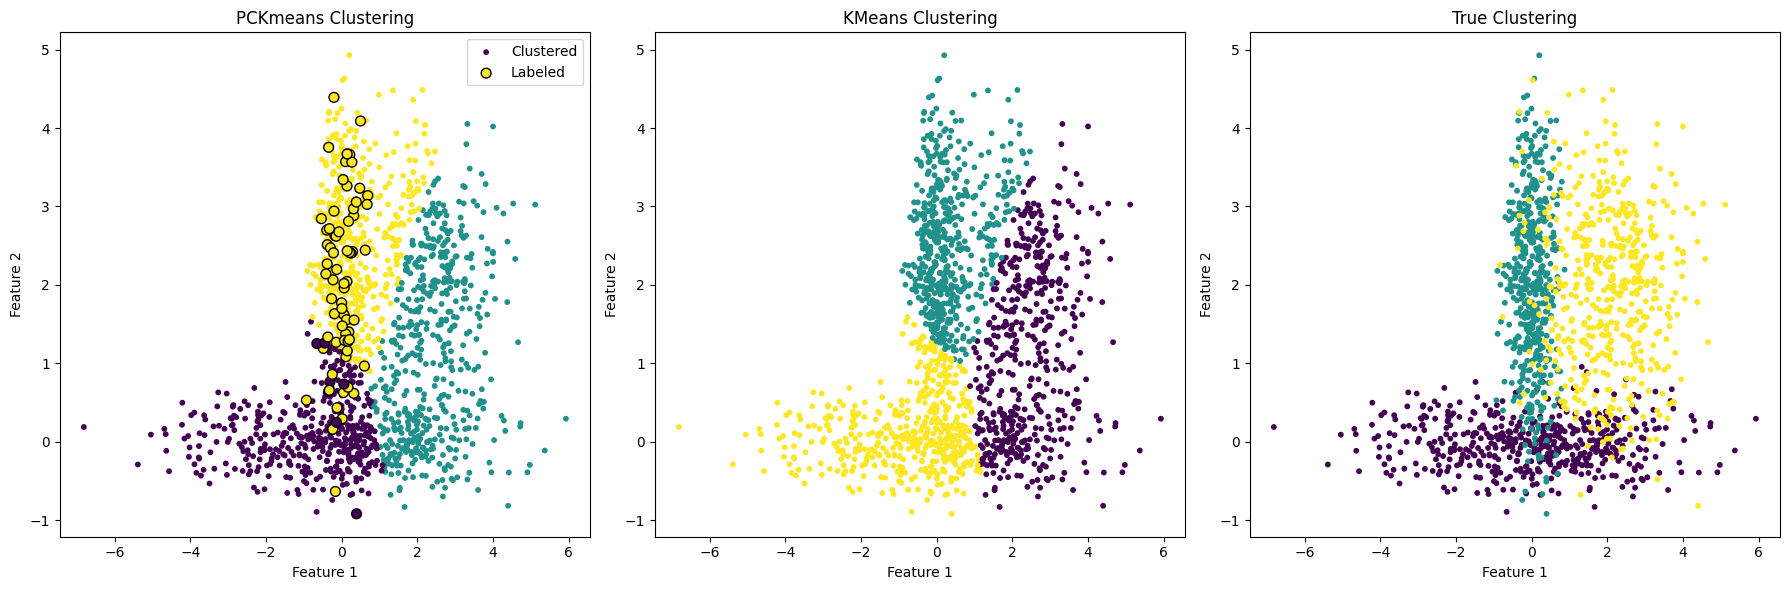

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.cluster import KMeans
from clustering import PCKmeans
from util import create_constraints, create_sparse_labels

%matplotlib inline

def test_pckmeans_vs_kmeans(args, n_clusters, n_points_per_cluster):
    """
    Compare PCKmeans and KMeans on synthetic data using multiple metrics.
    """

    # Set random seed for reproducibility
    seed = args['seed']
    np.random.seed(seed)
    random.seed(seed)

    # 1) Generate synthetic data
    # means = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(n_clusters)]
    # covs = [
    #     [[random.uniform(0.5, 1.5), 0], [0, random.uniform(0.5, 1.5)]] for _ in range(n_clusters)
    # ]
    #init highly assymetric non-random covariances
    means = [[0, 0], [0, 2], [2, 2]]
    covs = [
        [[4, 0], [0, 0.1]],
        [[0.1, 0], [0, 1]],
        [[1, 0], [0, 1]]
    ]

    X_list = []
    y_list = []
    for idx, (mean, cov) in enumerate(zip(means, covs)):
        X_cluster = np.random.multivariate_normal(mean, cov, n_points_per_cluster)
        y_cluster = np.full(n_points_per_cluster, idx)
        X_list.append(X_cluster)
        y_list.append(y_cluster)

    X = np.vstack(X_list)
    y_true = np.concatenate(y_list)

    # 2) Define constraints using external utility function
    dataset = [(X[i], y_true[i]) for i in range(len(X))]
    partial_labeled_data, labeled_indices = create_sparse_labels(args, dataset)
    constraints = create_constraints(args, partial_labeled_data, labeled_indices)

    # 3) Instantiate and run PCKmeans
    pck = PCKmeans(
        k=n_clusters,
        device='cpu',
        plot=False,
        constraints=constraints,
        labeled_indices=labeled_indices,
        max_iter=args['kmeans_iters']
    )

    # fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig, axes = None, None
    pck.cluster(
        X=X, 
        true_labels=y_true, 
        epoch=0, 
        fig=fig, 
        axes=axes, 
        verbose=False
    )

    # Get PCKmeans results
    pck_labels = pck.labels_

    # 4) Instantiate and run KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans_labels = kmeans.fit_predict(X)

    # 5) Evaluate metrics for both methods
    metrics = {
        'NMI': normalized_mutual_info_score,
        'Silhouette': silhouette_score,
        'ARI': adjusted_rand_score,
        'DBI': davies_bouldin_score
    }

    results = {}
    for name, metric in metrics.items():
        if name == 'Silhouette':  # Silhouette score needs the data as well
            results[f'PCKmeans_{name}'] = metric(X, pck_labels)
            results[f'KMeans_{name}'] = metric(X, kmeans_labels)
        elif name == 'DBI':  # DBI needs the data as well
            results[f'PCKmeans_{name}'] = metric(X, pck_labels)
            results[f'KMeans_{name}'] = metric(X, kmeans_labels)
        else:
            results[f'PCKmeans_{name}'] = metric(y_true, pck_labels)
            results[f'KMeans_{name}'] = metric(y_true, kmeans_labels)

    # Print comparison results
    print("\n===== Metrics Comparison =====")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    # 6) Plot the clusters
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # PCKmeans Clustering
    ax[0].scatter(X[:, 0], X[:, 1], c=pck_labels, cmap='viridis', s=10, label='Clustered')
    ax[0].scatter(X[list(labeled_indices), 0], X[list(labeled_indices), 1], c=pck_labels[list(labeled_indices)], cmap='viridis', s=50, edgecolors='k', label='Labeled')
    ax[0].set_title("PCKmeans Clustering")
    ax[0].set_xlabel("Feature 1")
    ax[0].set_ylabel("Feature 2")
    ax[0].legend()
    
    # KMeans Clustering
    ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=10)
    ax[1].set_title("KMeans Clustering")
    ax[1].set_xlabel("Feature 1")
    ax[1].set_ylabel("Feature 2")

    # True Clustering
    ax[2].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=10)
    ax[2].set_title("True Clustering")
    ax[2].set_xlabel("Feature 1")
    ax[2].set_ylabel("Feature 2")

    
    plt.tight_layout()
    plt.show()

# Run the test function
if __name__ == '__main__':
    
    n_clusters = 3  # Define number of clusters here
    n_points_per_cluster = 500  # Define points per cluster here

    args = {
        'cannot_link_fraction': 0.1,  # This is the fraction you want to use (1.0 = all constraints)
        'must_link_fraction': 0.1,  # This is the fraction you want to use (1.0 = all constraints)
        'nmb_labeled_clusters': 1, # Number of clusters to use for labeled data
        'nmb_cluster': n_clusters,
        'label_pattern': 'class_wise',
        'label_noise': 0.0,
        'kmeans_iters': 1,
        'verbose': True,
        'seed': 41,
        'label_fraction': 0.05,  # Fraction of labeled data
        'granularity': 1  # Granularity of constraints
    }
    test_pckmeans_vs_kmeans(args, n_clusters, n_points_per_cluster)
    
    args = {
        'cannot_link_fraction': 0.1,  # This is the fraction you want to use (1.0 = all constraints)
        'must_link_fraction': 0.1,  # This is the fraction you want to use (1.0 = all constraints)
        'nmb_labeled_clusters': 1, # Number of clusters to use for labeled data
        'nmb_cluster': n_clusters,
        'label_pattern': 'class_wise',
        'label_noise': 0.0,
        'kmeans_iters': 10,
        'verbose': True,
        'seed': 41,
        'label_fraction': 0.05,  # Fraction of labeled data
        'granularity': 1  # Granularity of constraints
    }
    test_pckmeans_vs_kmeans(args, n_clusters, n_points_per_cluster)